# Estimation de l'ATE/CATE sur des données synthétiques

In [1]:
import numpy as np
from scipy.stats import bernoulli
import scipy as sp
#from scipy import st
from scipy import integrate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 1.5})
plt.rcParams['figure.figsize'] = 10, 8

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install causalml

In [2]:
import causalml

## Génération de données synthétiques

In [3]:
def treatment_assign(Nobs, d, X, p):
    '''
    Input: 
    
    p : score de propension.
    Nobs : Nombre de lignes da la matrice X i.e. nombre de personnes.
    
    Output:
    
    W : Vecteur de taille Nobs contenant des 0 ou 1 pour désigner l'affectation du traitement.
    '''
    sigmoid = lambda x: 1/(1+np.exp(-x))
    
    omega = np.random.uniform(0, 1, (Nobs, d))
    psi = np.random.uniform(0, 1, (Nobs, 1))

    if p == None:
      p = np.zeros(Nobs)
      for i in range(Nobs):
        p[i] = sigmoid(omega[i] @ X[i])
      W = bernoulli.rvs(p, size = Nobs) 
    else:
      W = bernoulli.rvs(p, size = Nobs) 
    
    return W


def causal_generation(Nobs, dim, beta, bias, f, g, p):
    '''
    Input :
    
    Nobs : Nombre de lignes da la matrice X i.e. nombre de personnes.
    dim : Nombre de colonnes de la matrice X i.e. nombres de caractéristiques (features).
    beta : Vecteur de dimension (2, dim).
    bias : Vecteur de dimension (1, 2).
    W : Vecteur de dimension (1, Nobs) contenant des 0 ou 1 pour désigner 
    l'affectation du traitement.
    f et g sont des fonctions.
    
    Output:
    
    (X, Y, W) : Triplet contenant la matrice X des features, Y le vecteur des 
                résultats potentiels et W le vecteur de l'affectation du traitement.
    '''
    moy = np.zeros(dim)
    var = np.eye(dim)
    X = np.random.multivariate_normal(moy, var, Nobs)
    Y = np.zeros(Nobs)

    W = treatment_assign(Nobs, dim, X, p)

    for i in range(Nobs):
        bruit = np.random.normal(0, 1)
        if W[i] == 0:
            Y[i] = f(beta[0] @ X[i] + bias[0]) + bruit
        if W[i] == 1:
            Y[i] = g(beta[1] @ X[i] + bias[1]) + bruit
            
    return (X, W, Y)

## Métalearners internes

### S-learners

In [4]:
from sklearn.base import BaseEstimator, ClassifierMixin

class SLearner(BaseEstimator, ClassifierMixin):
    """ Homemade SLearner class """
    
    def __init__(self, base_estimator=LinearRegression()):
        # init
        self.estimator = base_estimator
        
    def fit(self, X, W, Y):
        # Initiation des variables
        self.X = X
        self.W = W
        self.Y = Y
        self.features = np.hstack((self.X, self.W[:,np.newaxis]))
        self.clf = self.estimator.fit(self.features, self.Y)

    def predict_CATE(self, x):
        # Complete the method      
        self.Y_0_hat = self.clf.predict(np.c_[x, np.zeros(len(x))])
        self.Y_1_hat = self.clf.predict(np.c_[x, np.ones(len(x))])
        return self.Y_1_hat - self.Y_0_hat

    def predict_ATE(self):
        return (self.Y_1_hat - self.Y_0_hat).mean()

### T-learners

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin

class TLearner(BaseEstimator, ClassifierMixin):
    """ Homemade TLearner class """
    
    def __init__(self, base_estimator0=LinearRegression(), base_estimator1=LinearRegression() ):
        # init
        self.estimator0 = base_estimator0
        self.estimator1 = base_estimator1

    def fit(self, X, W, Y):
        # Initiation des variables
        self.X = X
        self.W = W
        self.Y = Y
        self.mu_0 = self.estimator0.fit(X[self.W==0,:], self.Y[self.W==0])
        self.mu_1 = self.estimator1.fit(X[self.W==1,:], self.Y[self.W==1])

    def predict_CATE(self, x):
        # Complete the method         
        self.Y_0_hat = self.mu_0.predict(x)
        self.Y_1_hat = self.mu_1.predict(x)
        return self.Y_1_hat - self.Y_0_hat

    def predict_ATE(self):
        return (self.Y_1_hat - self.Y_0_hat).mean()

### X-Learners ( a vérifier)

In [6]:
from sklearn.base import BaseEstimator, ClassifierMixin

class XLearner(BaseEstimator, ClassifierMixin):
    """ Homemade XLearner class """
    
    def __init__(self, outcome_learner0 = LinearRegression(), outcome_learner1 = LinearRegression(), 
                 effect_learner0 = LinearRegression(), effect_learner1 = LinearRegression()):
        # init
        self.outcome_learner0 = outcome_learner0
        self.outcome_learner1 = outcome_learner1
        self.effect_learner0 = effect_learner0
        self.effect_learner1 = effect_learner1

    def fit(self, X, W, Y):
        # Initiation des variables
        self.X = X
        self.W = W
        self.Y = Y 
        
        #Stage 1 : Estimate the average outcomes μ0(x) and  μ1(x)
        self.mu_0 = self.outcome_learner0.fit(X[self.W==0,:], self.Y[self.W==0])
        self.mu_1 = self.outcome_learner1.fit(X[self.W==1,:], self.Y[self.W==1])
        
        #Stage 2 : Impute the user level treatment effects
        self.D0 = self.mu_1.predict(X[self.W==0,:]) - self.Y[self.W==0] 
        self.D1 = self.Y[self.W==1] - self.mu_0.predict(X[self.W==1,:])    
        
        #estimate τ1(x) = E[D1|X=x], and τ0(x) = E[D0|X=x] using machine learning models:
        self.tau_0 = self.effect_learner0 .fit(X[self.W==0,:], self.D0)
        self.tau_1 = self.effect_learner0 .fit(X[self.W==1,:], self.D1)
        

    def predict_CATE(self, x, p):
        # Complete the method         
        self.CATE_hat = p*self.tau_0.predict(x) + (1-p)*self.tau_1.predict(x)
        return self.CATE_hat

    def predict_ATE(self):
        return (self.CATE_hat).mean()

### DR-Learners ( a vérifier)

In [7]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

class DRLearner(BaseEstimator, ClassifierMixin):
    """ Homemade DRLearner class """
    
    def __init__(self, model_regression = LinearRegression(), model_propensity = LogisticRegression(), 
                 model_final = LinearRegression()):
        # init
        self.model_regression = model_regression
        self.model_propensity = model_propensity
        self.model_final = model_final
        

    def fit(self, X, W, Y):
        # Initiation des variables
        self.X = X
        self.W = W
        self.Y = Y 
        
        #Stage 1 : Regression of the outcomes μ(X,T) = E[Y|X,W,T]
        self.features = np.hstack((self.X, self.W[:,np.newaxis]))
        self.mu = self.model_regression.fit(self.features, self.Y)
        
        #Stage 1 : Model to estimate the propensity_score
        self.model_propensity = CalibratedClassifierCV(self.model_propensity)
        self.model_propensity.fit(self.X, self.W)
        self.propensity = self.model_propensity.predict_proba(X)

        #Stage 1 : predict Y_pred
        self.Y_pred_0 = self.mu.predict(np.hstack((self.X, np.zeros((self.X.shape[0],1)))))
        self.Y_pred_0 += (Y - self.Y_pred_0) * (1 - self.W) / self.propensity[:,0]
        self.Y_pred_1 = self.mu.predict(np.hstack((self.X, np.ones((self.X.shape[0],1)))))
        self.Y_pred_1 += (Y - self.Y_pred_1) * (self.W) / self.propensity[:,1]
        
        #Stage 2 : fit model final
        self.model_final.fit(self.X, self.Y_pred_1 - self.Y_pred_0)
        

    def predict_CATE(self, x):
        # Complete the method         
        self.CATE_hat = self.model_final.predict(x)
        return self.CATE_hat

    def predict_ATE(self):
        return (self.CATE_hat).mean()

## Phase de test

### Initialisation des paramètres

In [8]:
N = 1000
d = 2                                       # d = 2, afin de pouvoir être calculé par intégration et par Monte Carlo
p = 0.5
beta0 = np.random.uniform(1, 30, (1, d))
beta1 = np.random.uniform(2000,4000, (1, d))
beta = np.vstack((beta0,beta1))               # beta0 = beta1           
bias = np.array([100,10])                 # beta0 = beta1, cas simple pour faciliter l'interprétation des résultats                              # Gamma0 != Gamma1, biais différent
f = lambda x:x
g = lambda x:x

### Générations des données

In [9]:
# Génération des données
X, W, Y = causal_generation(N, d, beta, bias, f, g, p)

### Prédictions des métalearners "Team Filrouge"

#### Slearners

In [10]:
base_learner=LinearRegression()

In [11]:
from sklearn.ensemble import RandomForestRegressor

In [12]:
slearner=SLearner(base_estimator=RandomForestRegressor())
slearner.fit(X,W,Y)

cate_hat_S = slearner.predict_CATE(X)
print("- Les dimensions du CATE = {}.".format(cate_hat_S.shape))

ate_hat_S = slearner.predict_ATE()
print("- L'estimation de la valeur de l'ATE = {}.".format(ate_hat_S))

- Les dimensions du CATE = (1000,).
- L'estimation de la valeur de l'ATE = 135.46758069374246.


#### Tlearners

In [13]:
tlearner=TLearner(base_estimator0=RandomForestRegressor(),base_estimator1=RandomForestRegressor())
tlearner.fit(X,W,Y)

cate_hat_T = tlearner.predict_CATE(X)
print("- Les dimensions du CATE = {}.".format(cate_hat_S.shape))

ate_hat_T = tlearner.predict_ATE()
print("- L'estimation de la valeur de l'ATE = {}.".format(ate_hat_T))

- Les dimensions du CATE = (1000,).
- L'estimation de la valeur de l'ATE = 143.7683280986416.


#### Xlearners

In [14]:
def propensity_score(X, W, clf = LogisticRegression()):
    # calibration of the classifier
    cls = CalibratedClassifierCV(clf)

    # training of the classifier
    cls.fit(X, W)

    # predicton of the classifier
    propensity = cls.predict_proba(X)[:,1]

    return propensity

(array([ 14.,  46.,  89., 176., 206., 199., 170.,  57.,  30.,  13.]),
 array([0.47671358, 0.4815867 , 0.48645982, 0.49133294, 0.49620606,
        0.50107918, 0.5059523 , 0.51082542, 0.51569854, 0.52057166,
        0.52544478]),
 <BarContainer object of 10 artists>)

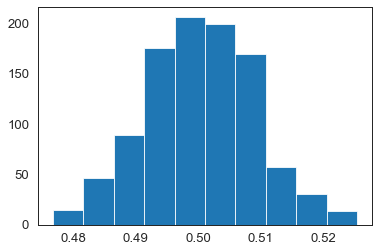

In [15]:
propensity=propensity_score(X, W)

plt.hist(propensity)

In [16]:
xlearner=XLearner()
xlearner.fit(X,W,Y)

cate_hat_T = xlearner.predict_CATE(X, propensity)
print("- Les dimensions du CATE = {}.".format(cate_hat_S.shape))

ate_hat_T = xlearner.predict_ATE()
print("- L'estimation de la valeur de l'ATE = {}.".format(ate_hat_T))

- Les dimensions du CATE = (1000,).
- L'estimation de la valeur de l'ATE = 127.4160080949145.


#### DRlearners

In [17]:
X.shape, W.shape, Y.shape

((1000, 2), (1000,), (1000,))

In [18]:
drlearner=DRLearner()
drlearner.fit(X,W,Y)

cate_hat_T = drlearner.predict_CATE(X)
print("- Les dimensions du CATE = {}.".format(cate_hat_T.shape))

ate_hat_T = drlearner.predict_ATE()
print("- L'estimation de la valeur de l'ATE = {}.".format(ate_hat_T))

- Les dimensions du CATE = (1000,).
- L'estimation de la valeur de l'ATE = 133.6780427397235.


### Prédictions des métalearners "Causal ML"

#### Slearners

In [70]:
from causalml.inference.meta import LRSRegressor
from xgboost import XGBRegressor


lr = LRSRegressor()
te, lb, ub = lr.estimate_ate(X, W, Y)
print('L\'estimation de la valeur de l\'ATE (Linear Regression): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

L'estimation de la valeur de l'ATE (Linear Regression): -89.94 (-90.07, -89.82)


#### Tlearners

In [71]:
from causalml.inference.meta import XGBTRegressor

xg = XGBTRegressor(random_state=42)
te, lb, ub = xg.estimate_ate(X, W, Y)
print('L\'estimation de la valeur de l\'ATE (XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

L'estimation de la valeur de l'ATE (XGBoost): -90.15 (-90.29, -90.01)


#### Xlearners

In [72]:
from causalml.inference.meta import BaseXRegressor
from xgboost import XGBRegressor


#le propensity score est calculé automatiquement par le modèle
xl = BaseXRegressor(learner=XGBRegressor())
te, lb, ub = xl.estimate_ate(X, treatment = W, y = Y, p = None)
print('Average Treatment Effect (BaseXRegressor using XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))


Average Treatment Effect (BaseXRegressor using XGBoost): -90.09 (-90.17, -90.00)


#### DRlearners

In [73]:
import econml
from econml.drlearner import DRLearner

est = DRLearner()
est.fit(Y, W, X=X, W=None)

print('L\'estimation de la valeur de l\'ATE (): {:.2f})'.format(est.effect(X).mean()))

L'estimation de la valeur de l'ATE (): -89.94)


In [74]:
est.effect(X)

array([-89.99991764, -89.85861157, -89.86072109, -89.89158232,
       -89.99023741, -89.89782743, -89.93376671, -89.89114295,
       -89.87370599, -90.00406251, -89.97749091, -89.97982202,
       -89.91720692, -90.00431766, -89.9322361 , -89.90536634,
       -90.00246269, -89.97564614, -89.97471676, -89.9258119 ,
       -89.97877369, -89.94122736, -89.89696851, -89.95226138,
       -89.97274275, -89.98007958, -90.01294196, -90.00542782,
       -89.9777517 , -89.9490885 , -89.88840983, -89.94404091,
       -89.90687693, -89.99421525, -89.94455214, -89.94827335,
       -89.88330134, -89.9178758 , -89.98220347, -89.99292206,
       -89.95583195, -89.92277847, -89.96593238, -89.88252758,
       -89.93668777, -89.95446105, -89.95426972, -89.90439393,
       -89.87930565, -89.89787604, -89.97510299, -89.85632748,
       -89.95907274, -89.9410762 , -89.95771734, -89.92413954,
       -89.93652824, -89.91764982, -89.93952315, -89.93784984,
       -89.89036811, -89.89431878, -89.9160789 , -89.94

### Prédictions "Paradis"

#### Calcul MSE

In [19]:
def MSE(y,y_pred):
    return 1/2*(y-y_pred)**2

#### Calcul de l'ATE

In [20]:
def ATE_paradis(beta, bias, f=lambda i:i, g=lambda i:i):
    p=beta.shape[1]
    if p==1:
        ate = integrate.quad(lambda x: (g(beta[1]*x + bias[1]) -f(beta[0]*x + bias[0]))*sp.stats.norm.pdf(x,0,1),-1000 , 1000)
    if p==2:
        ate=integrate.dblquad(lambda x, y: (g(beta[1,0]*x + beta[1,1]*y + bias[1]) -f(beta[0,0]*x + beta[0,1]*y + bias[0])
                                           )*sp.stats.norm.pdf(x,0,1)*sp.stats.norm.pdf(y,0,1),-1000 , 1000, lambda y :-1000,lambda y : 1000)
    if p>2:
        raise Warning('dimension above 2')
    return  ate

In [21]:
def monte_carlo(Nobs, dim, beta, bias, f, g, W):
    '''
    Input :
    
    Nobs : Nombre de lignes da la matrice X i.e. nombre de personnes.
    dim : Nombre de colonnes de la matrice X i.e. nombres de caractéristiques (features).
    beta : Vecteur de dimension (2, dim), note dim doit être < 10
    bias : Vecteur de dimension (1, 2).
    W : Vecteur de dimension (1, Nobs) contenant des 0 ou 1 pour désigner l'affectation du traitement.
    f et g sont des fonctions.
    
    Output:
    
    ATE : ATE calculé par la méthode de Monte Carlo
    '''
    moy = np.zeros(dim)
    var = np.eye(dim)
    X = np.random.multivariate_normal(moy, var, Nobs)
    ATE = np.mean(g(X.dot(beta[1])+ bias[1]) - f(X.dot(beta[0])+ bias[0])) 
            
    return ATE

In [22]:
print('ATE calculé par intégration: {}'.format(ATE_paradis(beta, bias, f=f, g=g)))
print('ATE calculé par Monte Carlo: {}'.format(monte_carlo(10**6, d, beta, bias, f, g, W)))

ATE calculé par intégration: (-89.99999999995957, 8.239932487719148e-08)
ATE calculé par Monte Carlo: -84.72884244179949


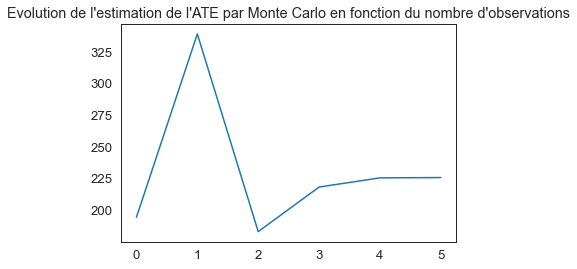

In [23]:
res = []
#1- varier Nobs pour ate_hat_S et le comparer avec mc_est (meth. monte carlo) avec 10**8
#2 - ajouter une courbe avec l'estimation avec causalml avec la borne inf et max et ate_hat_S
for i in range(2,8):
    mc_est = monte_carlo(10**i, d, beta, bias, f, g, W)
    res.append([abs(mc_est - ate_hat_S)])
plt.figure()
plt.title('Evolution de l\'estimation de l\'ATE par Monte Carlo en fonction du nombre d\'observations')
plt.plot(res);

#### Calcul des Intervalles de Confiance de l'ATE

In [24]:
def causal_generation_bootstrap(beta, bias, B= 999, Nobs =1000, dim=2, f=lambda i:i, g=lambda i:i, p=None):
    '''
    Create list of bootstrap elements
    Input :
    
    B : Nombre d'échantillons Boostrap, 999 est une valeur par défaut pertinente
    Nobs : Nombre de lignes da la matrice X i.e. nombre de personnes, 1000 par défaut
    dim : Nombre de colonnes de la matrice X i.e. nombres de caractéristiques 
    (features), 2 par défaut
    beta : Vecteur de dimension (2, dim).
    bias : Vecteur de dimension (1, 2).
    W : Vecteur de dimension (1, Nobs) contenant des 0 ou 1 pour désigner 
    l'affectation du traitement.
    f et g sont des fonctions, identité par défaut
    
    Output:
    
    [(X, W, Y)] : liste de B Triplets contenant la matrice X des features, W 
    le vecteur de l'affectation du traitement et Y le vecteur des résultats 
    potentiels. 
                
    '''
    Bootstraps=[]

    for b in range(B):
        Bootstraps.append(causal_generation(Nobs, dim, beta, bias, f, g, p))
      
    return Bootstraps

In [25]:
def IC(Bootstraps, base_metalearner=SLearner(),alpha=0.05):
    
    '''
    Calculate l'intervalle de confiance d'un métalearner
    
    Input :
    
    Bootstraps : Liste d'échantillons Boostraps comprenant B triplets (X,Y,W)
    base_metalerner : metalearner à évaluer
    
    Output:
    
    IC : (IC inf , IC sup) du métalearner 
    '''
    #import
    from scipy.stats import norm
    
    #Calcul de l'ATE les B estimateurs du Bootstrap
    ATEs=np.zeros((len(Bootstraps)))

    for i in range(len(Bootstraps)):
        base_metalearner.fit(Bootstraps[i][0],Bootstraps[i][1],Bootstraps[i][2])
        
        if type(base_metalearner) is XLearner:
            propensity=propensity_score(Bootstraps[i][0], Bootstraps[i][1])
            base_metalearner.predict_CATE(Bootstraps[i][0], propensity)
        else:
            base_metalearner.predict_CATE(Bootstraps[i][0])
        ATEs[i]=base_metalearner.predict_ATE()
    
    #Calcul des intervalles de confiance
    Mu_ATEs= ATEs.mean()
    std_ATEs= ATEs.std()
    ATEs_tilt= (ATEs-Mu_ATEs)/std_ATEs
    ATEs_tilt.sort()
    ATEs.sort()
    IC_inf, IC_sup = ATEs[int(B*(alpha/(2)))], ATEs[int(B*(1-alpha/(2)))]
    
    return (Mu_ATEs, IC_inf, IC_sup)

In [26]:
B=999
Bootstraps=causal_generation_bootstrap(beta, bias, B= B, Nobs =N, dim=d, f=f, g=g, p=p)
IC(Bootstraps, base_metalearner=SLearner(),alpha=0.05)

(-94.11134098860593, -372.3859819127638, 204.34128775836865)

In [27]:
B=999
Bootstraps=causal_generation_bootstrap(beta, bias, B= B, Nobs =N, dim=d, f=f, g=g, p=p)
IC(Bootstraps, base_metalearner=TLearner(),alpha=0.05)

(-80.33528788218973, -384.3907603787811, 218.68187473543023)

In [28]:
B=999
Bootstraps=causal_generation_bootstrap(beta, bias, B= B, Nobs =N, dim=d, f=f, g=g, p=p)
IC(Bootstraps, base_metalearner=XLearner(),alpha=0.05)

(-81.0747113569056, -359.57592471773114, 212.8489933767927)

In [29]:
B=5
Bootstraps=causal_generation_bootstrap(beta, bias, B= B, Nobs =N, dim=d, f=f, g=g, p=p)
IC(Bootstraps, base_metalearner=DRLearner(),alpha=0.05)

(-59.971538415585755, -249.55493540957792, 52.65154474345414)

### Comparaison graphiques des résultats

In [30]:
def graphic_comparison(nb_obs, d, p, beta, bias, f, g, B, base_learner_homemade, base_learner_causalml):

  '''
  Create a graphic to compare our bases learners vs base learners from causalml 

  Input :
    
  B : Nombre d'échantillons Boostrap, 999 est une valeur par défaut pertinente
  nb_obs : Nombre de lignes da la matrice X, les listes sont acceptables i.e. nombre de personnes, 1000 par défaut
  dim : Nombre de colonnes de la matrice X i.e. nombres de caractéristiques (features), 2 par défaut
  beta : Vecteur de dimension (2, dim).
  bias : Vecteur de dimension (1, 2).
  W : Vecteur de dimension (1, Nobs) contenant des 0 ou 1 pour désigner l'affectation du traitement.
  f et g sont des fonctions, identité par défaut
    
  Output:
  Graphique comparant nos base_learner avec ceux du causal_ml
  '''

  ate_causal_ml = []
  lb_causal_ml = []
  ub_causal_ml = []

  ates = []
  ates_inf = []
  ates_sup = []

  for n in nb_obs:

    # Génération des données
    Bootstraps=causal_generation_bootstrap(beta, bias, B= B, Nobs =n, dim=d, f=f, g=g, p=p) 
    mu, inf, sup = IC(Bootstraps, base_metalearner=base_learner_homemade, alpha=0.05)
    ates.append(mu)
    ates_inf.append(inf)
    ates_sup.append(sup)

    # S learner causal ML
    X, W, Y = causal_generation(n, d, beta, bias, f, g, p)
    lr = base_learner_causalml
    te, lb, ub = lr.estimate_ate(X, W, Y)
    ate_causal_ml.append(te[0])
    lb_causal_ml.append(lb[0])
    ub_causal_ml.append(ub[0])


  plt.plot(nb_obs,ates, color='blue',label = 'ATE_homemade')
  plt.fill_between(nb_obs, ates_inf,ates_sup,alpha = 0.5, color='blue', label = 'IC_ATE_homemade')
  plt.plot(nb_obs, ate_causal_ml,color='orange',label='ATE_causal_ml')
  plt.fill_between(nb_obs, lb_causal_ml, ub_causal_ml,alpha = 0.5, color='orange',label='IC_ATE_causalml')
  plt.legend()
  plt.show()
  

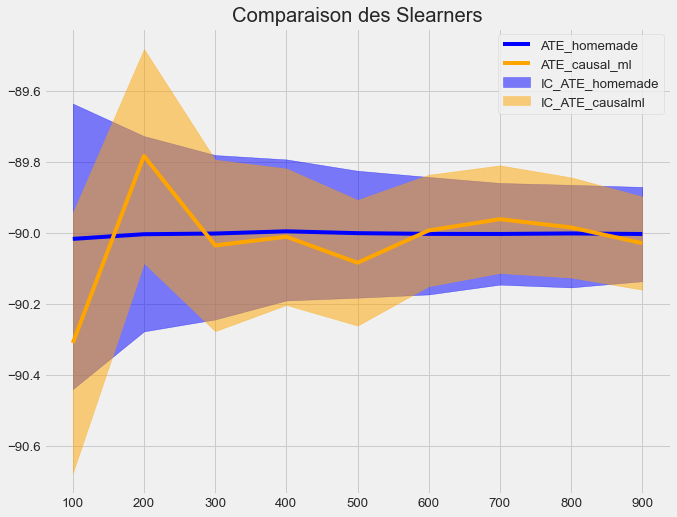

In [36]:
nb_obs = [i for i in range(100,1000,100)]
plt.title('Comparaison des Slearners');
graphic_comparison(nb_obs, d, p, beta, bias, f, g, B, SLearner(), LRSRegressor())

In [ ]:
nb_obs = [i for i in range(100,1000,100)]
plt.title('Comparaison des Tlearners');
graphic_comparison(nb_obs, d, p, beta, bias, f, g, B, TLearner(), XGBTRegressor())

# Test sur clustering

In [47]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
import tp_knn_source
from copy import deepcopy

In [48]:
# paramètres pour faciliter le calcul de l'ATE par intégration
N = 500
d = 2                                     # d = 2, afin de pouvoir être calculé par intégration et avec Monte Carlo
p = 0.5
beta0 = np.random.uniform(1, 30, (1, d))
beta1 = np.random.uniform(1, 100, (1, d))
beta = np.vstack((beta0,beta0))               # beta0 = beta1           
bias = np.array([0,10])                       # Gamma0 = Gamma1 
f = lambda x:x
g = lambda x:x

In [33]:
def causal_generation_bigauss(Nobs, dim, beta, bias, f, g, p):
    '''
    Input :
    
    Nobs : Nombre de lignes da la matrice X i.e. nombre de personnes.
    dim : Nombre de colonnes de la matrice X i.e. nombres de caractéristiques (features).
    beta : Vecteur de dimension (2, dim).
    bias : Vecteur de dimension (1, 2).
    W : Vecteur de dimension (1, Nobs) contenant des 0 ou 1 pour désigner 
    l'affectation du traitement.
    f et g sont des fonctions.
    
    Output:
    
    (X, Y, W) : Triplet contenant la matrice X des features, Y le vecteur des 
                résultats potentiels et W le vecteur de l'affectation du traitement.
    '''
    moy = np.zeros(dim)
    var = np.eye(dim)
    n1 = int(Nobs/2)
    n2 = Nobs-n1
    X, _= tp_knn_source.rand_bi_gauss(n1=n1, n2=n2, mu1=[1, 1], mu2=[0.5, 0.5], sigmas1=[0.5, 0.1],
                  sigmas2=[0.1, 0.1])
    
    Y = np.zeros(Nobs)

    W = treatment_assign(Nobs, dim, X, p)

    for i in range(Nobs):
        bruit = np.random.normal(0, 1)
        if W[i] == 0:
            Y[i] = f(beta[0] @ X[i] + bias[0]) + bruit
        if W[i] == 1:
            Y[i] = g(beta[1] @ X[i] + bias[1]) + bruit
            
    return (X, W, Y)

In [34]:
# Génération des données
X, W, Y = causal_generation_bigauss(N, d, beta, bias, f, g, p)

## Clustering sur les features

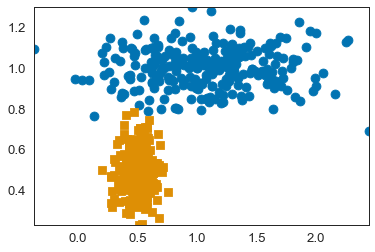

In [35]:
gmm = GaussianMixture(n_components=2)
gmm.fit(X)
groups=gmm.predict(X)
#Plot
data=[X, groups]
tp_knn_source.plot_2d(data[0],data[1])

In [36]:
def clustering_features(X, W, Y, n_components = 2 ,cluster_model = 'gaussian', 
                        base_metalearner=SLearner(base_estimator=LinearRegression())):
    
    #Clusters identification
    if cluster_model == 'gaussian':
        clf = GaussianMixture(n_components=n_components)
    else:
        clf = KMeans(n_clusters=n_components)
    clf.fit(X)
    groups=clf.predict(X)
    labels=np.unique(groups)
    
    #CATE et ATE Calculation per cluster
    ates={}
    base_metalearner.fit(X,W,Y)
        
    if type(base_metalearner) is XLearner:
        propensity=propensity_score(X, W)
        cate_hat = base_metalearner.predict_CATE(X, propensity)
    else:
        cate_hat = base_metalearner.predict_CATE(X)
    print("- Les dimensions du CATE pour le groupe complet sont de {}.".format(cate_hat.shape))    
    
    ate_hat = base_metalearner.predict_ATE()
    print("- L'estimation de la valeur de l'ATE pour le groupe complet = {}.".format(ate_hat))
    
    for label in labels:
        idx_group=groups==label             
        print("- Les dimensions du CATE pour le groupe {} sont de {}.".format(label,cate_hat[idx_group].shape))
        ate_hat =cate_hat[idx_group].mean()
        print("- L'estimation de la valeur de l'ATE pour le groupe {} = {}.".format(label, ate_hat))
        ates[label] = ate_hat
    return ates

In [37]:
clustering_features(X, W, Y, n_components = 3 ,cluster_model = 'gaussian', 
                        base_metalearner=XLearner())

- Les dimensions du CATE pour le groupe complet sont de (500,).
- L'estimation de la valeur de l'ATE pour le groupe complet = 10.065529452800815.
- Les dimensions du CATE pour le groupe 0 sont de (251,).
- L'estimation de la valeur de l'ATE pour le groupe 0 = 10.010580873115826.
- Les dimensions du CATE pour le groupe 1 sont de (132,).
- L'estimation de la valeur de l'ATE pour le groupe 1 = 10.103104386279904.
- Les dimensions du CATE pour le groupe 2 sont de (117,).
- L'estimation de la valeur de l'ATE pour le groupe 2 = 10.141018361191346.


{0: 10.010580873115826, 1: 10.103104386279904, 2: 10.141018361191346}

## Clustering sur le CATE

In [38]:
def clustering_cate(X, W, Y, n_components = 2 ,cluster_model = 'gaussian', 
                        base_metalearner=SLearner(base_estimator=LinearRegression())):
    
    #CATE Calculation
    ates={}
    base_metalearner.fit(X,W,Y)
    
    if type(base_metalearner) is XLearner:
        propensity=propensity_score(X, W)
        cate_hat = base_metalearner.predict_CATE(X, propensity)
    else:
        cate_hat = base_metalearner.predict_CATE(X)
       
    print("- Les dimensions du CATE pour le groupe complet sont de {}.".format(cate_hat.shape))
    ate_hat = base_metalearner.predict_ATE()
    print("- L'estimation de la valeur de l'ATE pour le groupe complet = {}.".format(cate_hat.mean()))
    
    #Clusters identification
    CATE=cate_hat.reshape(-1, 1)
    if cluster_model == 'gaussian':
        clf = GaussianMixture(n_components=n_components)
    else:
        clf = KMeans(n_clusters=n_components)
    clf.fit(CATE)
    groups=clf.predict(CATE)
    labels=np.unique(groups)
    
    #CATE et ATE Calculation per cluster
    ates={}
    for label in labels:
        idx_group=groups==label             
        print("- Les dimensions du CATE pour le groupe {} sont de {}.".format(label,cate_hat[idx_group].shape))
        ate_hat =cate_hat[idx_group].mean()
        print("- L'estimation de la valeur de l'ATE pour le groupe {} = {}.".format(label, ate_hat))
        ates[label] = ate_hat
    
    return ates

In [39]:
clustering_cate(X, W, Y, n_components = 3 ,cluster_model = 'gaussian', 
                        base_metalearner=SLearner(base_estimator=RandomForestRegressor()))

- Les dimensions du CATE pour le groupe complet sont de (500,).
- L'estimation de la valeur de l'ATE pour le groupe complet = 9.859501799349596.
- Les dimensions du CATE pour le groupe 0 sont de (366,).
- L'estimation de la valeur de l'ATE pour le groupe 0 = 9.960678807586161.
- Les dimensions du CATE pour le groupe 1 sont de (84,).
- L'estimation de la valeur de l'ATE pour le groupe 1 = 8.293181287135244.
- Les dimensions du CATE pour le groupe 2 sont de (50,).
- L'estimation de la valeur de l'ATE pour le groupe 2 = 11.750304559578048.


{0: 9.960678807586161, 1: 8.293181287135244, 2: 11.750304559578048}

### Clustering Hybrid

In [40]:
def clustering_hybrid(X, W, Y, n_components = 2 ,cluster_model = 'gaussian', 
                        base_metalearner=SLearner(base_estimator=LinearRegression())):
    
    #CATE Calculation
    ates={}
    base_metalearner.fit(X,W,Y)

    if type(base_metalearner) is XLearner:
        propensity=propensity_score(X, W)
        cate_hat = base_metalearner.predict_CATE(X, propensity)
    else:
        cate_hat = base_metalearner.predict_CATE(X)

    print("- Les dimensions du CATE pour le groupe complet sont de {}.".format(cate_hat.shape))
    ate_hat = base_metalearner.predict_ATE()
    print("- L'estimation de la valeur de l'ATE pour le groupe complet = {}.".format(cate_hat.mean()))

    #hybrid features calculation
    CATE=cate_hat.reshape(-1, 1)
    features = np.hstack((X,CATE))

    #Clusters identification
    if cluster_model == 'gaussian':
        clf = GaussianMixture(n_components=n_components)
    else:
        clf = KMeans(n_clusters=n_components)
    clf.fit(features)
    groups=clf.predict(features)
    labels=np.unique(groups)
    
    #cluster calculation (might be wrong)
    for label in labels:
        idx_group=groups==label             
        print("- Les dimensions du CATE pour le groupe {} sont de {}.".format(label,cate_hat[idx_group].shape))
        ate_hat =cate_hat[idx_group].mean()
        print("- L'estimation de la valeur de l'ATE pour le groupe {} = {}.".format(label, ate_hat))
        ates[label] = ate_hat
    
    return ates

In [41]:
clustering_hybrid(X, W, Y, n_components = 2 ,cluster_model = 'gaussian', 
                        base_metalearner=SLearner(base_estimator=RandomForestRegressor()))

- Les dimensions du CATE pour le groupe complet sont de (500,).
- L'estimation de la valeur de l'ATE pour le groupe complet = 9.856031294608655.
- Les dimensions du CATE pour le groupe 0 sont de (251,).
- L'estimation de la valeur de l'ATE pour le groupe 0 = 9.875531250982098.
- Les dimensions du CATE pour le groupe 1 sont de (249,).
- L'estimation de la valeur de l'ATE pour le groupe 1 = 9.836374712079609.


{0: 9.875531250982098, 1: 9.836374712079609}

### Generic clustering function

#### Fonction clustering qui calcule aussi le cate et l'ate

In [42]:
def clustering_ext(X, W, Y, n_components = 2 , approach ='hybrid', cluster_model = 'gaussian', 
                        base_metalearner=SLearner(base_estimator=LinearRegression()),verbose=False):
    """Clustering function
    The function shall be fed with X, W and Y and will calculate .
    -cluster models available are : 'gaussian' for GMM and KNN for None or others,
    -Clustering approaches avalable are 'features', 'cate' and 'hybrid' for (cate + hybrid)
    returns dictionnaries of ates, cates """
    
    #CATE et ATE calculation per cluster
    ates={}
    cates={}
    base_metalearner.fit(X,W,Y)
        
    if type(base_metalearner) is XLearner:
        propensity=propensity_score(X, W)
        cate_hat = base_metalearner.predict_CATE(X, propensity)
    else:
        cate_hat = base_metalearner.predict_CATE(X)
    if verbose ==True:    
        print("- Les dimensions du CATE pour le groupe complet sont de {}.".format(cate_hat.shape))    
    
    ate_hat = base_metalearner.predict_ATE()
    if verbose ==True:
        print("- L'estimation de la valeur de l'ATE pour le groupe complet = {}.".format(ate_hat))
    
    #features calculation
    assert (approach=='hybrid' or 
            approach=='cate' or 
            approach=='features' ), "clustering method choosen differs from 'hybrid' or 'cate' or 'features'"
    if approach=='hybrid':
        features = np.hstack((X,cate_hat.reshape(-1, 1)))
    if approach=='cate':
        features=cate_hat.reshape(-1, 1)
    if approach=='features':
        features=X
    
    #Clusters identification
    if cluster_model == 'gaussian':
        clf = GaussianMixture(n_components=n_components)
    else:
        clf = KMeans(n_clusters=n_components)
    clf.fit(features)
    groups=clf.predict(features)
    labels=np.unique(groups)
    
    #CATEs et ATEs calculations per cluster
    for label in labels:
        idx_group=groups==label             
        if verbose ==True:
            print("- Les dimensions du CATE pour le groupe {} sont de {}.".format(label,cate_hat[idx_group].shape))
        cates[label] = cate_hat[idx_group]
        ate_hat =cate_hat[idx_group].mean()
        if verbose ==True:
            print("- L'estimation de la valeur de l'ATE pour le groupe {} = {}.".format(label, ate_hat))
        ates[label] = ate_hat
    return ates, cates

In [43]:
ate, cates = clustering_ext(X, W, Y, n_components = 2 ,approach='cate',cluster_model = 'knn', 
                        base_metalearner=SLearner(base_estimator=RandomForestRegressor()),verbose=True)

- Les dimensions du CATE pour le groupe complet sont de (500,).
- L'estimation de la valeur de l'ATE pour le groupe complet = 9.867545328990595.
- Les dimensions du CATE pour le groupe 0 sont de (235,).
- L'estimation de la valeur de l'ATE pour le groupe 0 = 9.019801215820314.
- Les dimensions du CATE pour le groupe 1 sont de (265,).
- L'estimation de la valeur de l'ATE pour le groupe 1 = 10.619318410481222.


#### Fonction clustering simple qui prend en entrée le cate et l'ate

In [44]:
def clustering(X, cate, ate, n_components = 2 , approach ='hybrid', cluster_model = 'gaussian', verbose=False):
    """Simplified clustering function. 
    The function shall be fed with X, cate and ate as it is not calculated into the function.
    -cluster models available are : 'gaussian' for GMM and KNN for None or others,
    -Clustering approaches avalable are 'features', 'cate' and 'hybrid' for (cate + hybrid)
    returns dictionnaries of ates, cates """
    
    assert X.shape[0]==cate.shape[0], 'dim of cate and X not compatible'
    assert isinstance(cate,np.ndarray), 'dim of cate and X not compatible'
    
    #CATE et ATE calculation per cluster
    ates={}
    cates={}

    if verbose ==True:    
        print("- Les dimensions du CATE pour le groupe complet sont de {}.".format(cate.shape))    
    if verbose ==True:
        print("- L'estimation de la valeur de l'ATE pour le groupe complet = {}.".format(ate))
    
    #features calculation
    assert (approach=='hybrid' or 
            approach=='cate' or 
            approach=='features' ), "clustering method choosen differs from 'hybrid' or 'cate' or 'features'"
    if approach=='hybrid':
        features = np.hstack((X,cate.reshape(-1, 1)))
    if approach=='cate':
        features=cate.reshape(-1, 1)
    if approach=='features':
        features=X
    
    #Clusters identification
    if cluster_model == 'gaussian':
        clf = GaussianMixture(n_components=n_components)
    else:
        clf = KMeans(n_clusters=n_components)
    clf.fit(features)
    groups=clf.predict(features)
    labels=np.unique(groups)
    
    #CATEs et ATEs calculations per cluster
    for label in labels:
        idx_group=groups==label             
        if verbose ==True:
            print("- Les dimensions du CATE pour le groupe {} sont de {}.".format(label,cate[idx_group].shape))
        cates[label] = cate[idx_group]
        ate_hat =cate[idx_group].mean()
        if verbose ==True:
            print("- L'estimation de la valeur de l'ATE pour le groupe {} = {}.".format(label, ate_hat))
        ates[label] = ate_hat
    return ates, cates

In [45]:
X.shape, W.shape, Y.shape

((500, 2), (500,), (500,))

In [173]:
slearner=SLearner(base_estimator=RandomForestRegressor())
slearner.fit(X,W,Y)
ate, cates = clustering(X, slearner.predict_CATE(X), slearner.predict_ATE(), 
                            n_components = 2 ,approach='cate',cluster_model = 'knn',verbose=True)

- Les dimensions du CATE pour le groupe complet sont de (500,).
- L'estimation de la valeur de l'ATE pour le groupe complet = 9.85411766155697.
- Les dimensions du CATE pour le groupe 0 sont de (260,).
- L'estimation de la valeur de l'ATE pour le groupe 0 = 10.65485927971566.
- Les dimensions du CATE pour le groupe 1 sont de (240,).
- L'estimation de la valeur de l'ATE pour le groupe 1 = 8.986647575218383.


## Improved Metalearners (drafts)

In [174]:
#from base import is_classifier, clone
from sklearn.utils import indexable, check_random_state, _safe_indexing
from sklearn.utils.validation import _check_fit_params
from sklearn.utils.validation import _num_samples
from sklearn.utils.validation import _deprecate_positional_args
from sklearn.utils.fixes import delayed
from sklearn.utils.metaestimators import _safe_split
from sklearn.metrics import check_scoring
from sklearn.metrics._scorer import _check_multimetric_scoring, _MultimetricScorer
from sklearn.exceptions import FitFailedWarning, NotFittedError
from sklearn.model_selection import check_cv
from sklearn.preprocessing import LabelEncoder
from sklearn.base import is_classifier, clone

### iSlearner

In [215]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import KFold

class iSLearner(BaseEstimator, ClassifierMixin):
    """
    Homemade SLearner class with clustering capabilities
    -cluster models available are : 'gaussian' for GMM and kmeans for None or others,
    -clustering approaches available are 'features', 'cate' and 'hybrid' for (cate + hybrid)
    -cv in option
    """
    
    def __init__(self, base_estimator=LinearRegression()):
        self.estimator = base_estimator
        
    def fit(self, X, W, Y, cv = None):
        self.X = X
        self.W = W
        self.Y = Y
        self.cv = cv
                
        if self.cv==None:
            self.features = np.hstack((self.X, self.W[:,np.newaxis]))
            self.clf = self.estimator.fit(self.features, self.Y)
        else:
            assert isinstance(self.cv, int),'cv must be an integer'
            self.kf = KFold(n_splits=self.cv, shuffle=False)
            self.splits = list(self.kf.split(self.X,self.W,self.Y))
            self.clfs = []
            for train, _ in self.splits:
                X_train = self.X[train]
                Y_train = self.Y[train]
                W_train = self.W[train]
                features = np.hstack((X_train, W_train[:,np.newaxis]))
                self.clfs.append(clone(self.estimator).fit(features, Y_train))
    
    def clustering_function(self):
        """
        Clustering function
        INPUTS:
        see function predict_CATE
        OUTPUTS:
        returns dictionnaries of ates, cates 
        """

        #CATE et ATE calculation
        cate_hat = self.Y_1_hat - self.Y_0_hat
        if self.verbose ==True:    
            print("- Les dimensions du CATE pour le groupe complet sont de {}.".format(cate_hat.shape))    
        if self.verbose ==True:
            print("- L'estimation de la valeur de l'ATE pour le groupe complet = {}.".format(cate_hat.mean()))

        #features calculation
        assert (self.approach=='hybrid' or 
                self.approach=='cate' or 
                self.approach=='features'), "clustering method choosen differs from 'hybrid' or 'cate' or 'features'"
        if self.approach=='hybrid':
            features = np.hstack((self.X,cate_hat.reshape(-1, 1)))
        if self.approach=='cate':
            features=cate_hat.reshape(-1, 1)
        if self.approach=='features':
            features=self.X

        #Clusters identification
        if self.cluster_model == 'gaussian':
            clf = GaussianMixture(n_components=self.n_components)
        else:
            clf = KMeans(n_clusters=self.n_components)
        clf.fit(features)
        groups=clf.predict(features)
        labels=np.unique(groups)

        #CATEs et ATEs calculations per cluster
        for label in labels:
            idx_group=groups==label             
            if self.verbose ==True:
                print("- Les dimensions du CATE pour le groupe {} sont de {}.".format(label,cate_hat[idx_group].shape))
            self.cates[label] = cate_hat[idx_group]
            ate_hat =cate_hat[idx_group].mean()
            if self.verbose ==True:
                print("- L'estimation de la valeur de l'ATE pour le groupe {} = {}.".format(label, ate_hat))
            self.ates[label] = ate_hat

    def predict_CATE(self, x, idx = None, cluster = False, clusters = None, n_components = 2, 
                     cluster_model = 'gaussian', clustering_method = 'hybrid', verbose=False):
        """
        INPUTS:
        x : samples of features x that will serve for prediction if self.cv = None
        idx : np.array of boolean that will serve to idenfify which features of self.X will be used for prediction
              if self.cv!=None
        cluster :  boolean to describe if clustering shall be activated
        clusters = np.array of lenght self.X witch provides labels for each features of self.X ( per example label {0,1})
              if clusters is not provided the clusters will be calclated with the "clustering_function" with "n_components"
        n_components : number of cluster to use if clusters = None and cluster = true, 2 per default
        cluster_model : type of clustering model if clusters = None and cluster = true, can be 'gaussian' or 'kmeans'
        clustering_method : type of clustreing features if clusters = None and cluster = true, 
              can be 'features', 'cate', 'hybrid'
        verbose: boolean display of print, False per default
        
        OUTPUTS:
        cates: np.array of lenght of x 
        """
        
        self.cluster = cluster                        
        self.clusters = clusters                      
        self.n_components = n_components
        self.cluster_model = cluster_model
        self.approach = clustering_method
        self.verbose = verbose
        self.idx=idx
        
        #prediction with and without cv
        if self.cv==None:
            self.Y_0_hat = self.clf.predict(np.c_[x, np.zeros(len(x))])
            self.Y_1_hat = self.clf.predict(np.c_[x, np.ones(len(x))])
        else:
            self.Y_0_hat = np.zeros((X.shape[0]))
            self.Y_1_hat = np.zeros((X.shape[0]))
            for i, (_, test) in enumerate(self.splits):
                X_test = self.X[test]
                self.Y_0_hat[test] = self.clfs[i].predict(np.c_[X_test, np.zeros(len(X_test))])
                self.Y_1_hat[test] = self.clfs[i].predict(np.c_[X_test, np.ones(len(X_test))])
            if isinstance(self.idx,np.ndarray):
                assert(self.idx.dtype.type == np.bool_), 'must be a boolean'
                self.Y_0_hat = self.Y_0_hat[self.idx]
                self.Y_1_hat = self.Y_1_hat[self.idx]
        
        if self.cluster == False:
            return self.Y_1_hat - self.Y_0_hat
        else :
            self.ates={}
            self.cates={}
            
            if isinstance(self.clusters,np.ndarray)==False: 
                self.clustering_function()
            else:
                assert self.clusters.shape[0]==self.X.shape[0], 'dim of clusters doesn\'t meet dim of observations'
                labels=np.unique(self.clusters)
                for label in labels:
                    idx_group=groups==label             
                    self.cates[label] = (self.Y_1_hat - self.Y_0_hat)[idx_group]
                    ate_hat =(self.Y_1_hat - self.Y_0_hat)[idx_group].mean()
                    self.ates[label] = ate_hat
            return self.cates

    def predict_ATE(self):
        if self.cluster == False:
            return (self.Y_1_hat - self.Y_0_hat).mean()
        else:
            return self.ates

In [216]:
slearner=iSLearner(base_estimator=RandomForestRegressor())
slearner.fit(X,W,Y)

cate_hat_S = slearner.predict_CATE(X)
print("- Les dimensions du CATE = {}.".format(cate_hat_S.shape))

ate_hat_S = slearner.predict_ATE()
print("- L'estimation de la valeur de l'ATE = {}.".format(ate_hat_S))

- Les dimensions du CATE = (500,).
- L'estimation de la valeur de l'ATE = 9.865186351013556.


In [257]:
slearner=iSLearner(base_estimator=RandomForestRegressor())
slearner.fit(X,W,Y)

cate_hat_S = slearner.predict_CATE(X, cluster = True)
print("- Les groupes du CATE = {}.".format(cate_hat_S.keys()))

ate_hat_S = slearner.predict_ATE()
print("- L'estimation de la valeur de l'ATE = {}.".format(ate_hat_S))

- Les groupes du CATE = dict_keys([0, 1]).
- L'estimation de la valeur de l'ATE = {0: 9.913552415941432, 1: 9.847579324902078}.


In [258]:
slearner=iSLearner(base_estimator=RandomForestRegressor())
slearner.fit(X,W,Y)

cate_hat_S = slearner.predict_CATE(X, cluster = True, verbose=True)
print("- Les groupes du CATE = {}.".format(cate_hat_S.keys()))

ate_hat_S = slearner.predict_ATE()
print("- L'estimation de la valeur de l'ATE = {}.".format(ate_hat_S))

- Les dimensions du CATE pour le groupe complet sont de (500,).
- L'estimation de la valeur de l'ATE pour le groupe complet = 9.844655756312063.
- Les dimensions du CATE pour le groupe 0 sont de (249,).
- L'estimation de la valeur de l'ATE pour le groupe 0 = 9.82120917109276.
- Les dimensions du CATE pour le groupe 1 sont de (251,).
- L'estimation de la valeur de l'ATE pour le groupe 1 = 9.867915516151136.
- Les groupes du CATE = dict_keys([0, 1]).
- L'estimation de la valeur de l'ATE = {0: 9.82120917109276, 1: 9.867915516151136}.


In [219]:
cate_hat_S = slearner.predict_CATE(X, cluster = True, n_components= 5)
print("- Les groupes du CATE = {}.".format(cate_hat_S.keys()))

ate_hat_S = slearner.predict_ATE()
print("- L'estimation de la valeur de l'ATE = {}.".format(ate_hat_S))

- Les groupes du CATE = dict_keys([0, 1, 2, 3, 4]).
- L'estimation de la valeur de l'ATE = {0: 10.38225560695561, 1: 9.09858971860478, 2: 12.632136443204171, 3: 10.064057479861107, 4: 8.241624373615755}.


In [220]:
cate_hat_S = slearner.predict_CATE(X, cluster = True, n_components= 5)
print("- Les groupes du CATE = {}.".format(cate_hat_S.keys()))

ate_hat_S = slearner.predict_ATE()
print("- L'estimation de la valeur de l'ATE = {}.".format(ate_hat_S))

- Les groupes du CATE = dict_keys([0, 1, 2, 3, 4]).
- L'estimation de la valeur de l'ATE = {0: 9.468683944354371, 1: 10.848780347748097, 2: 8.273788129481403, 3: 10.05664169444512, 4: 12.441705367310089}.


In [221]:
clusters = np.random.randint(0,2,(X.shape[0],1))
cate_hat_S = slearner.predict_CATE(X, cluster = True, clusters = clusters, n_components= 5, 
                     cluster_model = 'kmeans', clustering_method = 'cate')
print("- Les groupes du CATE = {}.".format(cate_hat_S.keys()))

ate_hat_S = slearner.predict_ATE()
print("- L'estimation de la valeur de l'ATE = {}.".format(ate_hat_S))

- Les groupes du CATE = dict_keys([0, 1]).
- L'estimation de la valeur de l'ATE = {0: 9.86901346266007, 1: 9.8804981443823}.


In [222]:
slearner=iSLearner(base_estimator=RandomForestRegressor())
slearner.fit(X,W,Y,cv=10)

cate_hat_S = slearner.predict_CATE(X)
print("- Les dimensions du CATE = {}.".format(cate_hat_S.shape))

ate_hat_S = slearner.predict_ATE()
print("- L'estimation de la valeur de l'ATE = {}.".format(ate_hat_S))

- Les dimensions du CATE = (500,).
- L'estimation de la valeur de l'ATE = 9.821962386115988.


In [225]:
idx = np.ones((X.shape[0]))
idx[:150]=0
idx= idx.astype(bool)

slearner=iSLearner(base_estimator=RandomForestRegressor())
slearner.fit(X,W,Y,cv=5)

cate_hat_S = slearner.predict_CATE(X, idx=idx)
print("- Les dimensions du CATE = {}.".format(cate_hat_S.shape))

ate_hat_S = slearner.predict_ATE()
print("- L'estimation de la valeur de l'ATE = {}.".format(ate_hat_S))

- Les dimensions du CATE = (350,).
- L'estimation de la valeur de l'ATE = 9.816710961614545.


### iTlearner

In [272]:
from sklearn.base import BaseEstimator, ClassifierMixin

class iTLearner(BaseEstimator, ClassifierMixin):
    """ Homemade TLearner class """
    
    def __init__(self, base_estimator0=LinearRegression(), base_estimator1=LinearRegression() ):
        # init
        self.estimator0 = base_estimator0
        self.estimator1 = base_estimator1

    def fit(self, X, W, Y, cv = None):
        self.X = X
        self.W = W
        self.Y = Y
        self.cv =cv
        if self.cv==None:
            self.mu_0 = self.estimator0.fit(X[self.W==0,:], self.Y[self.W==0])
            self.mu_1 = self.estimator1.fit(X[self.W==1,:], self.Y[self.W==1])
        else:
            assert isinstance(self.cv, int),'cv must be an integer'
            self.kf = KFold(n_splits=self.cv, shuffle=False)
            self.splits = list(self.kf.split(self.X,self.W,self.Y))
            self.mu_0s = []
            self.mu_1s = []
            for train, _ in self.splits:
                X_train = self.X[train]
                Y_train = self.Y[train]
                W_train = self.W[train]
                self.mu_0s.append(clone(self.estimator0).fit(X_train[W_train==0,:], Y_train[W_train==0]))
                self.mu_1s.append(clone(self.estimator1).fit(X_train[W_train==1,:], Y_train[W_train==1]))

    def clustering_function(self):
        """
        Clustering function
        INPUTS:
        see function predict_CATE
        OUTPUTS:
        returns dictionnaries of ates, cates 
        """

        #CATE et ATE calculation
        cate_hat = self.Y_1_hat - self.Y_0_hat
        if self.verbose ==True:    
            print("- Les dimensions du CATE pour le groupe complet sont de {}.".format(cate_hat.shape))    
        if self.verbose ==True:
            print("- L'estimation de la valeur de l'ATE pour le groupe complet = {}.".format(cate_hat.mean()))

        #features calculation
        assert (self.approach=='hybrid' or 
                self.approach=='cate' or 
                self.approach=='features'), "clustering method choosen differs from 'hybrid' or 'cate' or 'features'"
        if self.approach=='hybrid':
            features = np.hstack((self.X,cate_hat.reshape(-1, 1)))
        if self.approach=='cate':
            features=cate_hat.reshape(-1, 1)
        if self.approach=='features':
            features=self.X

        #Clusters identification
        if self.cluster_model == 'gaussian':
            clf = GaussianMixture(n_components=self.n_components)
        else:
            clf = KMeans(n_clusters=self.n_components)
        clf.fit(features)
        groups=clf.predict(features)
        labels=np.unique(groups)

        #CATEs et ATEs calculations per cluster
        for label in labels:
            idx_group=groups==label             
            if self.verbose ==True:
                print("- Les dimensions du CATE pour le groupe {} sont de {}.".format(label,cate_hat[idx_group].shape))
            self.cates[label] = cate_hat[idx_group]
            ate_hat =cate_hat[idx_group].mean()
            if self.verbose ==True:
                print("- L'estimation de la valeur de l'ATE pour le groupe {} = {}.".format(label, ate_hat))
            self.ates[label] = ate_hat
            
    
    def predict_CATE(self, x, idx = None, cluster = False, clusters = None, n_components = 2, 
                     cluster_model = 'gaussian', clustering_method = 'hybrid', verbose=False):
        """
        INPUTS:
        x : samples of features x that will serve for prediction if self.cv = None
        idx : np.array of boolean that will serve to idenfify which features of self.X will be used for prediction
              if self.cv!=None
        cluster :  boolean to describe if clustering shall be activated
        clusters = np.array of lenght self.X witch provides labels for each features of self.X ( per example label {0,1})
              if clusters is not provided the clusters will be calclated with the "clustering_function" with "n_components"
        n_components : number of cluster to use if clusters = None and cluster = true, 2 per default
        cluster_model : type of clustering model if clusters = None and cluster = true, can be 'gaussian' or 'kmeans'
        clustering_method : type of clustreing features if clusters = None and cluster = true, 
              can be 'features', 'cate', 'hybrid'
        verbose: boolean display of print, False per default
        
        OUTPUTS:
        cates: np.array of lenght of x 
        """
        
        self.cluster = cluster                        
        self.clusters = clusters                      
        self.n_components = n_components
        self.cluster_model = cluster_model
        self.approach = clustering_method
        self.verbose = verbose
        self.idx=idx
        
        if self.cv==None:       
            self.Y_0_hat = self.mu_0.predict(x)
            self.Y_1_hat = self.mu_1.predict(x)
        else:
            self.Y_0_hat = np.zeros((X.shape[0]))
            self.Y_1_hat = np.zeros((X.shape[0]))
            for i, (_, test) in enumerate(self.splits):
                X_test = self.X[test]
                self.Y_0_hat[test] = self.mu_0s[i].predict(X_test)
                self.Y_1_hat[test] = self.mu_1s[i].predict(X_test)
            if isinstance(self.idx, np.ndarray):
                assert(self.idx.dtype.type == np.bool_), 'must be a boolean'
                self.Y_0_hat = self.Y_0_hat[self.idx]
                self.Y_1_hat = self.Y_1_hat[self.idx]
    
        if self.cluster == False:
            return self.Y_1_hat - self.Y_0_hat
        else:
            self.ates={}
            self.cates={}
            if isinstance(self.clusters,np.ndarray)==False: 
                self.clustering_function()
            else:
                assert self.clusters.shape[0]==self.X.shape[0], 'dim of clusters doesn\'t meet dim of observations'
                labels=np.unique(self.clusters)
                for label in labels:
                    idx_group=groups==label             
                    self.cates[label] = (self.Y_1_hat - self.Y_0_hat)[idx_group]
                    ate_hat =(self.Y_1_hat - self.Y_0_hat)[idx_group].mean()
                    self.ates[label] = ate_hat
            return self.cates

    def predict_ATE(self):
        if self.cluster == False:
            return (self.Y_1_hat - self.Y_0_hat).mean()
        else:
            return self.ates

In [274]:
tlearner=iTLearner(base_estimator0=RandomForestRegressor(),base_estimator1=RandomForestRegressor())
tlearner.fit(X,W,Y, cv=None)

cate_hat_T = tlearner.predict_CATE(X)
print("- Les dimensions du CATE = {}.".format(cate_hat_T.shape))

ate_hat_T = tlearner.predict_ATE()
print("- L'estimation de la valeur de l'ATE = {}.".format(ate_hat_T))

- Les dimensions du CATE = (500,).
- L'estimation de la valeur de l'ATE = 9.951247026149463.


In [275]:
tlearner=iTLearner(base_estimator0=RandomForestRegressor(),base_estimator1=RandomForestRegressor())
tlearner.fit(X,W,Y, cv=4)

cate_hat_T = tlearner.predict_CATE(X)
print("- Les dimensions du CATE = {}.".format(cate_hat_T.shape))

ate_hat_T = tlearner.predict_ATE()
print("- L'estimation de la valeur de l'ATE = {}.".format(ate_hat_T))

- Les dimensions du CATE = (500,).
- L'estimation de la valeur de l'ATE = 9.913206949684977.


In [276]:
idx = np.ones((X.shape[0]))
idx[:100]=0
idx= idx.astype(bool)

tlearner=iTLearner(base_estimator0=RandomForestRegressor(),base_estimator1=RandomForestRegressor())
tlearner.fit(X,W,Y, cv=4)

cate_hat_T = tlearner.predict_CATE(X, idx=idx)
print("- Les dimensions du CATE = {}.".format(cate_hat_T.shape))

ate_hat_T = tlearner.predict_ATE()
print("- L'estimation de la valeur de l'ATE = {}.".format(ate_hat_T))


- Les dimensions du CATE = (400,).
- L'estimation de la valeur de l'ATE = 9.893752645792645.


In [277]:
tlearner=iTLearner(base_estimator0=RandomForestRegressor(),base_estimator1=RandomForestRegressor())
tlearner.fit(X,W,Y)

cate_hat_T = tlearner.predict_CATE(X, cluster = True)
print("- Les groupes du CATE = {}.".format(cate_hat_T.keys()))

ate_hat_T = tlearner.predict_ATE()
print("- L'estimation de la valeur de l'ATE = {}.".format(ate_hat_T))

- Les groupes du CATE = dict_keys([0, 1]).
- L'estimation de la valeur de l'ATE = {0: 9.99179269528359, 1: 9.873463963190002}.


In [278]:
cate_hat_T = tlearner.predict_CATE(X, cluster = True, n_components= 5)
print("- Les groupes du CATE = {}.".format(cate_hat_T.keys()))

ate_hat_T = tlearner.predict_ATE()
print("- L'estimation de la valeur de l'ATE = {}.".format(ate_hat_T))

- Les groupes du CATE = dict_keys([0, 1, 2, 3, 4]).
- L'estimation de la valeur de l'ATE = {0: 7.568369086077036, 1: 10.3510963824146, 2: 9.972426945558198, 3: 9.714253156781803, 4: 12.813094435211822}.


In [ ]:
iXLearner

In [280]:
from sklearn.base import BaseEstimator, ClassifierMixin

class iXLearner(BaseEstimator, ClassifierMixin):
    """ Homemade XLearner class """
    
    def __init__(self, outcome_learner0 = LinearRegression(), outcome_learner1 = LinearRegression(), 
                 effect_learner0 = LinearRegression(), effect_learner1 = LinearRegression()):
        # init
        self.outcome_learner0 = outcome_learner0
        self.outcome_learner1 = outcome_learner1
        self.effect_learner0 = effect_learner0
        self.effect_learner1 = effect_learner1

    def fit(self, X, W, Y, cv = None):
        # Initiation des variables
        self.X = X
        self.W = W
        self.Y = Y
        self.cv = cv
        
        if self.cv == None:
            #Stage 1 : Estimate the average outcomes μ0(x) and  μ1(x)
            self.mu_0 = self.outcome_learner0.fit(X[self.W==0,:], self.Y[self.W==0])
            self.mu_1 = self.outcome_learner1.fit(X[self.W==1,:], self.Y[self.W==1])

            #Stage 2 : Impute the user level treatment effects
            self.D0 = self.mu_1.predict(X[self.W==0,:]) - self.Y[self.W==0] 
            self.D1 = self.Y[self.W==1] - self.mu_0.predict(X[self.W==1,:])    

            #estimate τ1(x) = E[D1|X=x], and τ0(x) = E[D0|X=x] using machine learning models:
            self.tau_0 = self.effect_learner0 .fit(X[self.W==0,:], self.D0)
            self.tau_1 = self.effect_learner0 .fit(X[self.W==1,:], self.D1)
        else:
            assert isinstance(self.cv, int),'cv must be an integer'
            self.D0 = np.zeros((X.shape[0]))
            self.D1 = np.zeros((X.shape[0]))
            self.tau_0s = []
            self.tau_1s = []
            self.kf = KFold(n_splits=self.cv, shuffle=False)
            self.splits = list(self.kf.split(self.X,self.W,self.Y))
            for train, test in self.splits:
                X_train, X_test = self.X[train], self.X[test]
                Y_train, Y_test = self.Y[train], self.Y[test]
                W_train, W_test = self.W[train], self.W[test]
                mu_0 = self.outcome_learner0.fit(X_train[W_train==0,:], Y_train[W_train==0])
                mu_1 = self.outcome_learner1.fit(X_train[W_train==1,:], Y_train[W_train==1])
                self.D0[test] = mu_1.predict(X_test[W_test==0,:]) - Y_test[W_test==0]
                self.D1[test] = Y_test[W_test==1] - mu_0.predict(X_test[W_test==1,:])
                self.tau_0s.append(clone(self.effect_learner0).fit(X_train[W_train==0,:], self.D0[train]))
                self.tau_1s.append(clone(self.effect_learner1).fit(X_train[W_train==1,:], self.D1[train]))
            

    def predict_CATE(self, x, p):
        # Complete the method         
        
        if self.cv==None:       
            self.CATE_hat = p*self.tau_0.predict(x) + (1-p)*self.tau_1.predict(x)
        else:
            self.CATE_hat = np.zeros((X.shape[0]))
            for i, (_, test) in enumerate(self.splits):
                X_test = self.X[test]
                self.CATE_hat[test] = p*self.tau_0s[i].predict(X_test) + (1-p)*self.tau_1s[i].predict(X_test)
            if isinstance(self.idx, np.ndarray):
                assert(self.idx.dtype.type == np.bool_), 'must be a boolean'
                self.CATE_hat = self.CATE_hat[self.idx]
        
        return self.CATE_hat

    def predict_ATE(self):
        return (self.CATE_hat).mean()

## Comparatif des modèles

In [122]:
import pandas as pd
df = pd.DataFrame(columns = ['SLearner' , 'TLearner', 'XLearner' , 'DRLearner'], index=['0.5', '0.1', 'hybrid'])

In [125]:
from sklearn.ensemble import GradientBoostingRegressor
models ={0: LinearRegression(), 1: RandomForestRegressor(), 2:GradientBoostingRegressor()}
models

{0: LinearRegression(),
 1: RandomForestRegressor(),
 2: GradientBoostingRegressor()}

In [157]:
i = 2
N = 1000
d = 2                                       # d = 2, afin de pouvoir être calculé par intégration et par Monte Carlo
p = None
beta0 = np.random.uniform(1, 30, (1, d))
beta1 = np.random.uniform(1,30, (1, d))
beta = np.vstack((beta0,beta1))               # beta0 = beta1           
bias = np.array([100,10])                 # beta0 = beta1, cas simple pour faciliter l'interprétation des résultats                              # Gamma0 != Gamma1, biais différent
f = lambda x:x
g = lambda x:x

# Génération des données
X, W, Y = causal_generation(N, d, beta, bias, f, g, p)

In [158]:
slearner = SLearner(base_estimator=models[i])
tlearner = TLearner(base_estimator0=models[i],base_estimator1=deepcopy(models[i]))
xlearner = XLearner(outcome_learner0 = models[i], outcome_learner1 = deepcopy(models[i]), 
                 effect_learner0 = deepcopy(models[i]), effect_learner1 = deepcopy(models[i]))
drlearner = DRLearner(model_regression = models[i], model_propensity = LogisticRegression(), 
                 model_final = deepcopy(models[i]))
metalearners = { 'Slearner' : slearner,
              'TLearner' : tlearner,
               'XLearner' : xlearner,
               'DRLearner' : drlearner
              }

In [160]:
results = np.zeros((4,1))
for j,(name, metalearner) in enumerate(metalearners.items()):
    metalearner.fit(X,W,Y)
    if name == 'XLearner':
        cls = LogisticRegression()
        cls = CalibratedClassifierCV(cls)
        cls.fit(X, W)
        propensity = cls.predict_proba(X)[:,1]
        cate_hat_T = metalearner.predict_CATE(X,propensity)
    else:
        cate_hat_T = metalearner.predict_CATE(X)
    ate_hat_T = metalearner.predict_ATE()
    print("- ATE pour le metalearner {} = {}.".format(name, ate_hat_T))
    results[j]= ate_hat_T
df.iloc[i] = results.ravel()

- ATE pour le metalearner Slearner = -88.50578431129637.
- ATE pour le metalearner TLearner = -89.02184983914371.
- ATE pour le metalearner XLearner = -89.25197482587703.
- ATE pour le metalearner DRLearner = -88.78615131608478.


In [161]:
df

,SLearner,TLearner,XLearner,DRLearner
0.5,-90.049942,-90.049906,-90.049906,-90.049984
0.1,-89.920028,-89.889912,-90.139028,-89.994851
hybrid,-88.505784,-89.02185,-89.251975,-88.786151
